In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
path='/Users/yingyuxuan/Downloads/msk-redefining-cancer-treatment/data/'

In [46]:
# load the text train data  and text data
train_text= pd.read_csv(path+'training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
test_text= pd.read_csv(path+"test_text", sep='\|\|', header=None, skiprows=1, names=["ID","Text"])

train_variants= pd.read_csv(path+'training_variants')
test_variants=pd.read_csv(path+'test_variants')


In [44]:
# check the shape of each dataset
train_text.shape  , test_text.shape

((3321, 2), (5668, 2))

In [45]:
train_variants.shape ,test_variants.shape

((3321, 4), (5668, 3))

In [54]:
# before we remove those missing 
#text data we need to merge variants data and text data 
train = pd.merge(train_variants,train_text, how='left', on='ID')
test = pd.merge(test_variants,test_text, how='left', on='ID')

In [55]:
train.isnull().sum() # there are five missing data in text column

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [60]:
# remove missing values
df_train=train.dropna(axis=0).copy()
df_test=test.dropna(axis=0).copy()
df_train.shape, df_test.shape

((3316, 5), (5667, 4))

In [62]:
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# EDA

- ID (the id of the row used to link the mutation to the clinical evidence), 
- Gene (the gene where this genetic mutation is located), 
- Variation (the aminoacid change for this mutations),
- Class (1-9 the class this genetic mutation has been classified on)

## Class

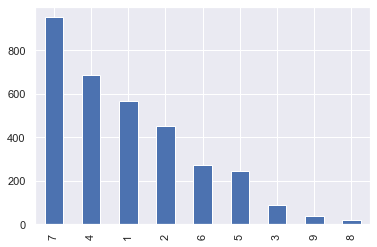

In [115]:
df_train.Class.value_counts().plot(kind="bar")

## Gene

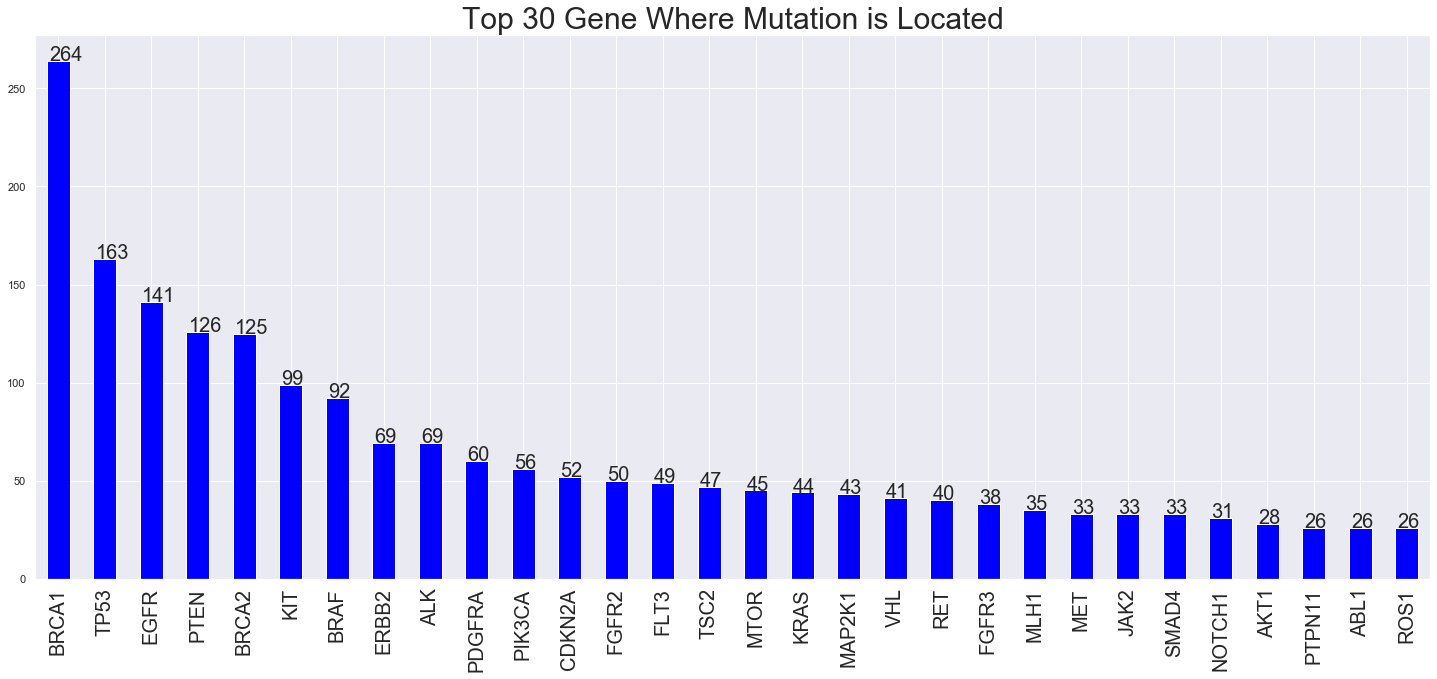

In [80]:
# Plot top 30 the frequency of the gene where this genetic mutation is located
df_train.Gene.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='blue')
plt.xticks(fontsize=20)
plt.title("Top 30 Genes Where Mutation is Located",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Gene.value_counts()[:30][i],"{}".format(df_train.Gene.value_counts()[:30][i]),fontsize=20)

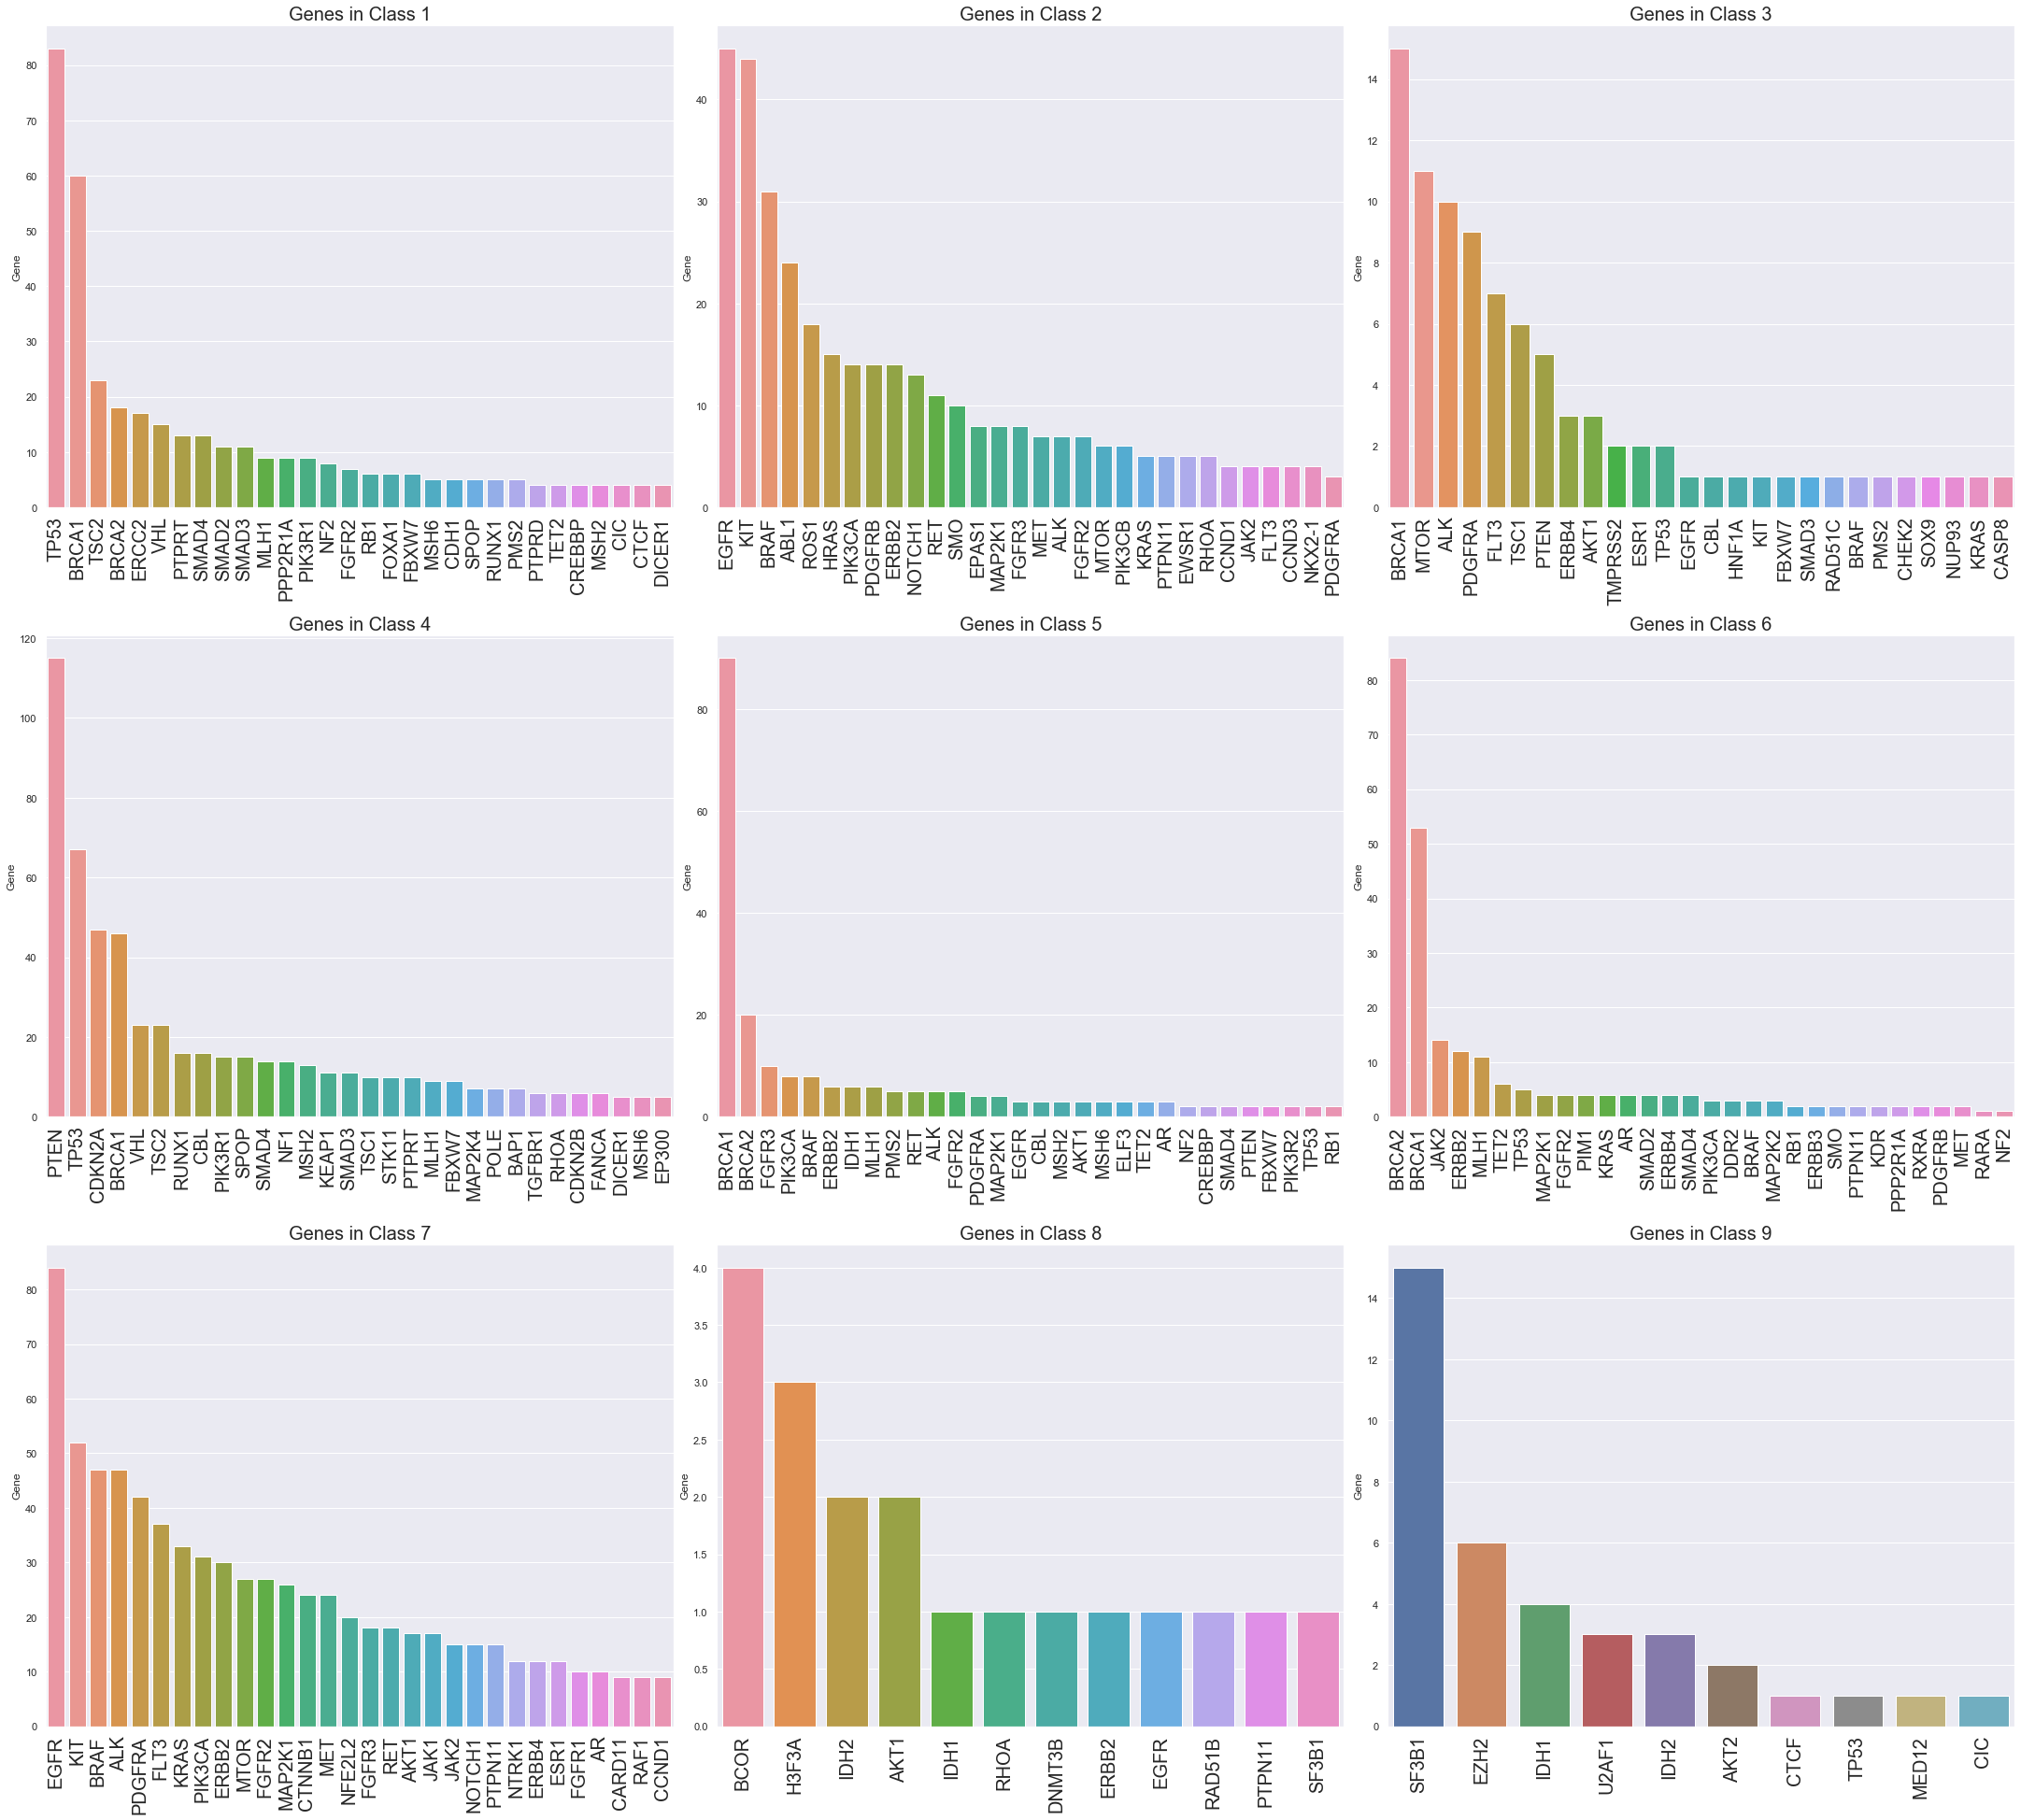

In [113]:
# Gene & Class
plt.figure(figsize=(30,27))
for i in range(0,9):
    class_df=pd.DataFrame(df_train[df_train.Class==i+1].Gene.value_counts()).reset_index()[:30]
    plt.subplot(3,3,i+1)
    sns.barplot(class_df['index'],class_df['Gene'])
    plt.xticks(rotation=90,size=20)
    plt.xlabel("")
    plt.title('Genes in Class {}'.format(list(set(df_train.Class))[i]),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Variation

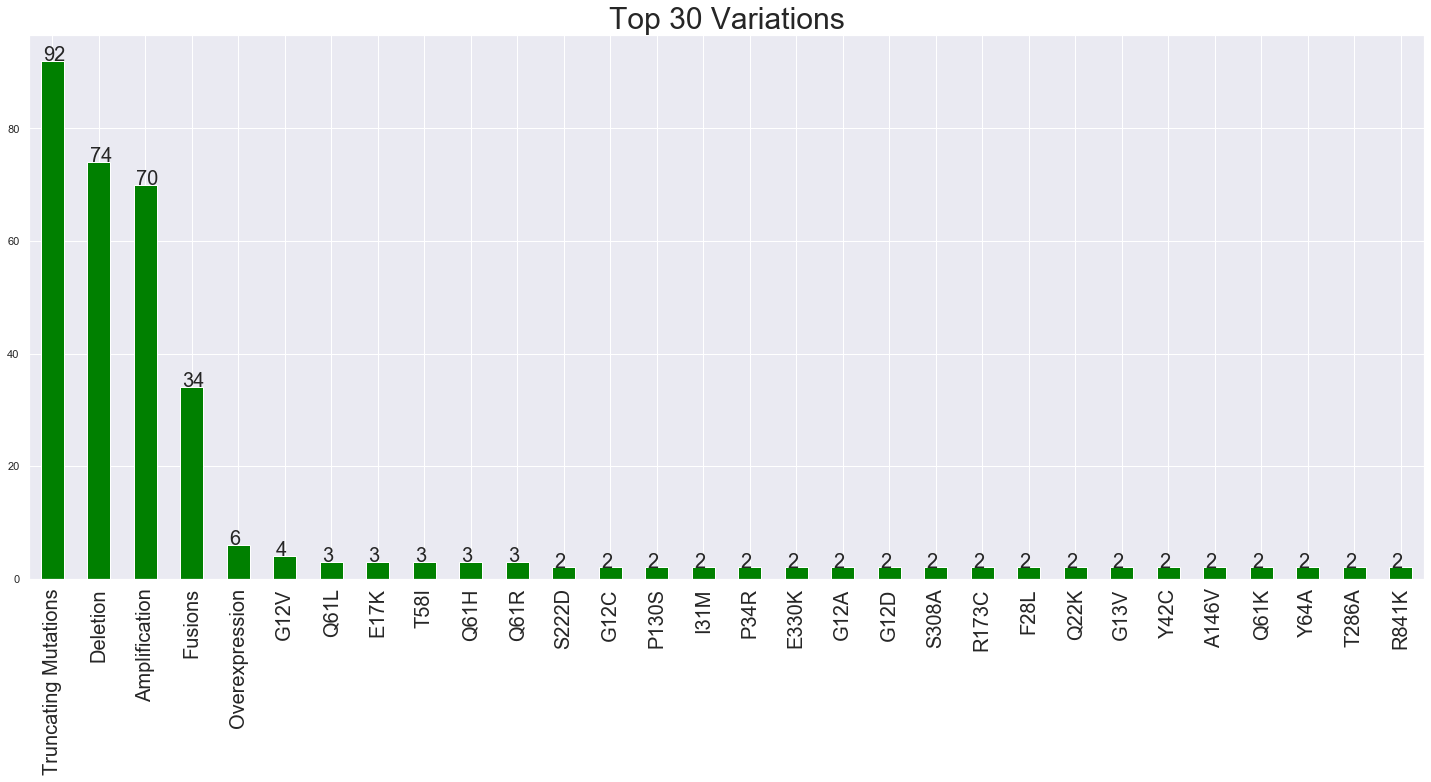

In [86]:
df_train.Variation.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='green')
plt.xticks(fontsize=20)
plt.title("Top 30 Variations",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Variation.value_counts()[:30][i],"{}".format(df_train.Variation.value_counts()[:30][i]),fontsize=20)

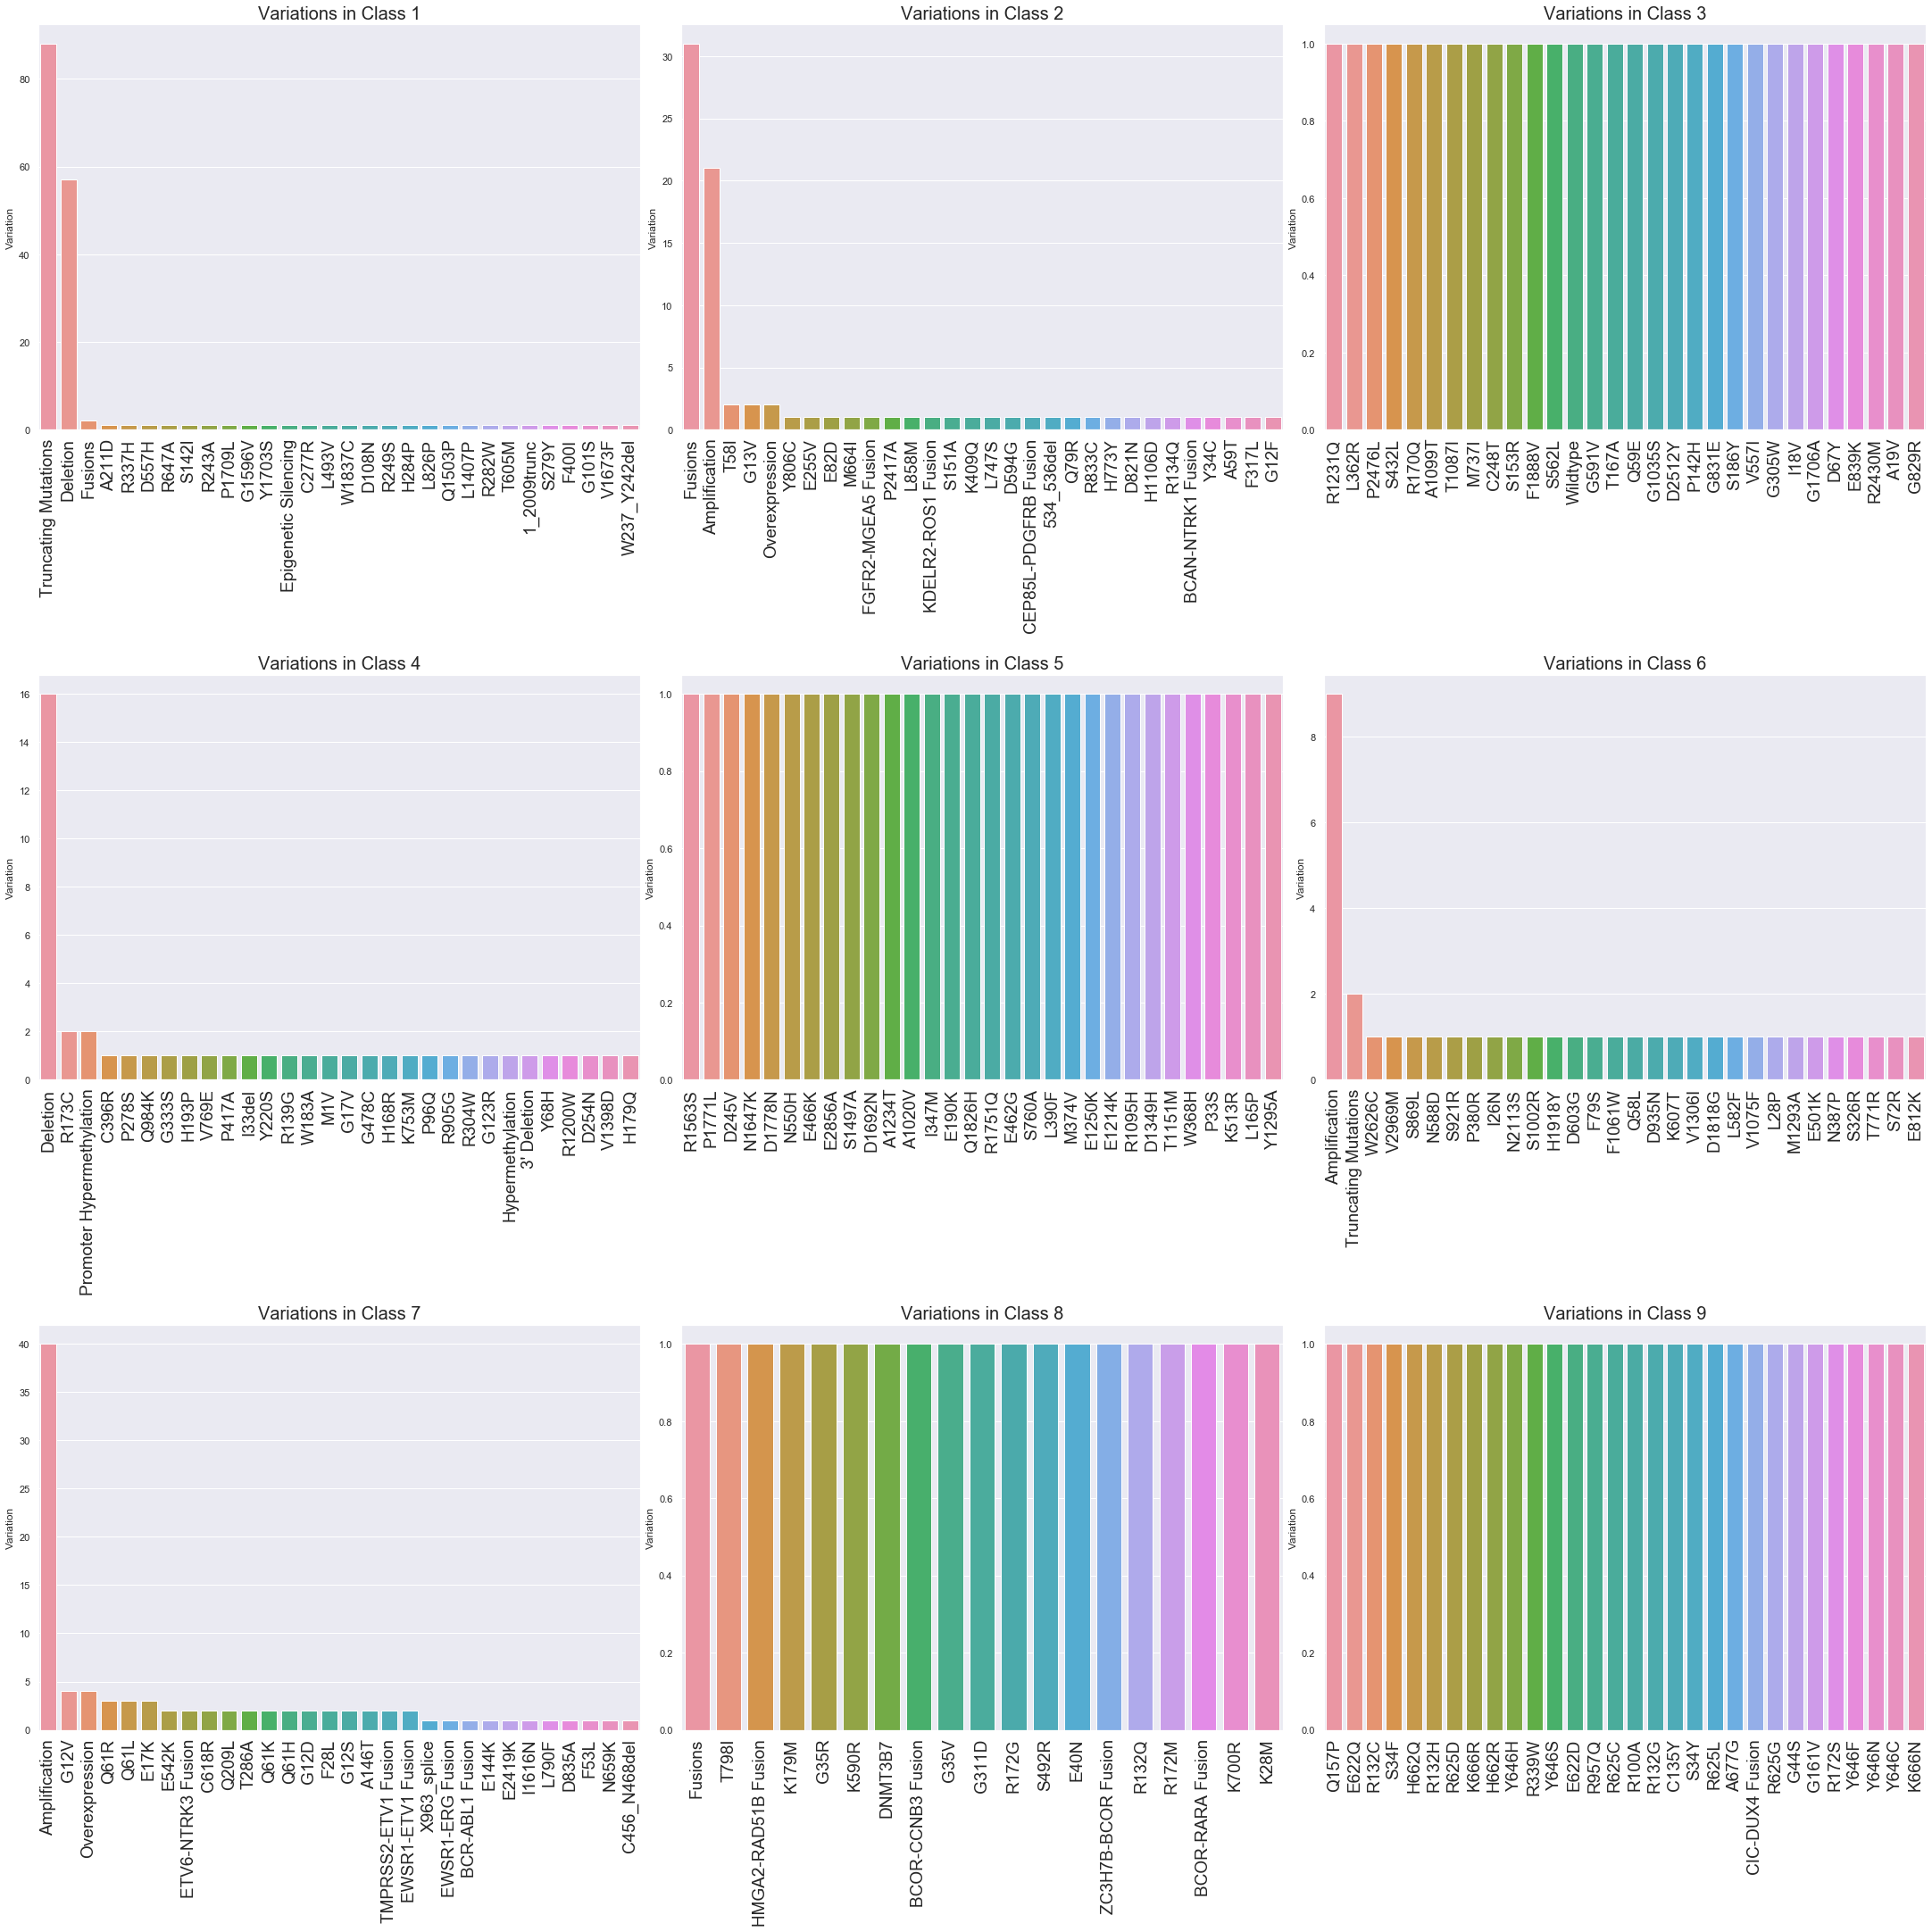

In [114]:
# Gene & Class
plt.figure(figsize=(30,30))
for i in range(0,9):
    class_df=pd.DataFrame(df_train[df_train.Class==i+1].Variation.value_counts()).reset_index()[:30]
    plt.subplot(3,3,i+1)
    sns.barplot(class_df['index'],class_df['Variation'])
    plt.xticks(rotation=90,size=19)
    plt.xlabel("")
    plt.title('Variations in Class {}'.format(list(set(df_train.Class))[i]),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Data Preprocessing

In [123]:
# Create functions for tokenization, stemming, Lelemmatization and 
# finally combine all functions together to obtain cleaned_text_date for train and test data
import re, string
from nltk.corpus import stopwords
import nltk

sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', 
'—', '_','satirewire.com',"/"]
sw_set = set(sw_list)

# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review) # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]# stop workds removal
    return stopwords_removed

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews


In [124]:
cleaned_train_text=data_preprocessing(df_train['Text'])

In [125]:
cleaned_test_text=data_preprocessing(df_test['Text'])

In [130]:
import pickle
pickle_out1=open('cleaned_train_text', 'wb')
pickle_out2=open('cleaned_test_text', 'wb')

pickle.dump(cleaned_train_text, pickle_out1)
pickle.dump(cleaned_test_text, pickle_out2)

pickle_out1.close()
pickle_out2.close()

In [132]:
pickle_in_train = open("cleaned_train_text","rb")
pickle_in_test= open("cleaned_test_text","rb")

cleaned_train_text = pickle.load(pickle_in_train)
cleaned_test_text= pickle.load(pickle_in_test)

## N-grams


In [135]:
df_train['cleaned_text']=cleaned_train_text
df_test['cleaned_text']=cleaned_test_text

In [134]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [ ]:
class1 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class2=  get_top_n_bigram(df_train[df_train['Class']==0]['cleaned_text'], 30)
class3 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class4 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class5 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class6 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class7 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class8 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class9 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
